## Set up script


In [76]:
# Import libs
import numpy as np

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

print("Num GPUs Available: ", torch.cuda.device_count())
print("Current GPU: ", torch.cuda.get_device_name(0))

Num GPUs Available:  1
Current GPU:  NVIDIA H100 80GB HBM3


In [77]:
# Random seed 
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

## Generate training data


In [78]:
#Represillator Parameters - uniform across nodes
b, g, kH, nH = 4.0, 1.0, 1.0, 3.0

#Dense Grid
lower_limits = np.array([0.8, 0.8, 0.8], dtype=np.float32)
upper_limits = np.array([1.7, 1.7, 1.7], dtype=np.float32)
num_per_axis = 100
axes = [np.linspace(l, u, num_per_axis, dtype=np.float32) for l, u in zip(lower_limits, upper_limits)]
x1v, x2v, x3v = np.meshgrid(*axes, indexing="ij")

#Targets
xdot1_train = b / (1.0 + (x3v / kH) ** nH) - g * x1v
xdot2_train = b / (1.0 + (x1v / kH) ** nH) - g * x2v
xdot3_train = b / (1.0 + (x2v / kH) ** nH) - g * x3v

#Flatten
x_train    = np.stack([x1v.ravel(), x2v.ravel(), x3v.ravel()], axis=1).astype("float32")
xdot_train = np.stack([xdot1_train.ravel(), xdot2_train.ravel(), xdot3_train.ravel()], axis=1).astype("float32")

#Random Split
idx = np.random.permutation(x_train.shape[0])

#Use a smaller subset 
small_sample_train_size = 50000
if x_train.shape[0] > small_sample_train_size:
    idx = np.random.permutation(x_train.shape[0])[:small_sample_train_size]
else:
    idx = np.arange(x_train.shape[0])

#Train Val Split
n_val = int(0.1 * idx.size)
val_idx, tr_idx = idx[:n_val], idx[n_val:]
x_tr, y_tr = x_train[tr_idx], xdot_train[tr_idx]
x_val, y_val = x_train[val_idx], xdot_train[val_idx]

In [ ]:
# Convert to tensors and create DataLoaders for batching
x_tr_tensor = torch.tensor(x_tr, dtype=torch.float32)
y_tr_tensor = torch.tensor(y_tr, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

batch_size = 32
train_dataset = TensorDataset(x_tr_tensor, y_tr_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Set up RNGRN model

In [80]:
# Model size
N = 3

#Custom Gated Competitive Promoter layer
class GatedCompetitivePromoter(nn.Module):
    def __init__(self):
        super().__init__()
        self.N = N

        #Parameterise to ensure positivity
        self.theta_s = nn.Parameter(torch.normal(0.5, 0.1, (N,N)))
        self.theta_g = nn.Parameter(torch.full((N, N), -0.5))
        self.theta_beta = nn.Parameter(torch.full((N,), -1.0))
        self.theta_alpha = nn.Parameter(torch.full((N,N), 0.5))
        self.theta_delta = nn.Parameter(torch.full((N,), 0.5))

    
    def forward(self, x):
        x2 = torch.square(x)

        self.s = torch.nn.functional.softplus(self.theta_s)
        self.g = torch.sigmoid(self.theta_g)
        KA = self.s * self.g
        KR = self.s * (1 - self.g)

        sum_A = torch.matmul(x2, KA.T)
        sum_R = torch.matmul(x2, KR.T)
        denom = 1 + sum_A + sum_R + 1e-8
        GA_matrix = (x2[:, None, :] * KA[None, :, :]) / denom[:, :, None]

        alpha = torch.nn.functional.softplus(self.theta_alpha)
        delta = torch.nn.functional.softplus(self.theta_delta)
        beta  = torch.nn.functional.softplus(self.theta_beta)
        activation = (GA_matrix * alpha[None, :, :]).sum(dim=2)
        xdot = beta + activation - delta * x
        return xdot
    
    def mapped_params(self):
        s = torch.nn.functional.softplus(self.theta_s).detach().cpu().numpy()
        g = torch.sigmoid(self.theta_g).detach().cpu().numpy()
        KA = s * g
        KR = s * (1 - g)
        alpha = torch.nn.functional.softplus(self.theta_alpha).detach().cpu().numpy()
        delta = torch.nn.functional.softplus(self.theta_delta).detach().cpu().numpy()
        beta  = torch.nn.functional.softplus(self.theta_beta).detach().cpu().numpy()
        return KA, KR, alpha, delta, beta

In [81]:
#Gate Projector
class GateProjector:
    def __init__(self, layer_name="GatedCompetitivePromoter", thr=0.1, hard_K=1.0):
        self.layer_name = layer_name
        self.thr = float(thr)
        self.hard_K = float(hard_K)
    
    def apply(self, model):
        layer = model
        g = torch.sigmoid(layer.theta_g)  
        low = g < self.thr
        high = g > (1.0 - self.thr)
        theta = layer.theta_g.clone()  
        theta = torch.where(low, -self.hard_K * torch.ones_like(theta), theta)
        theta = torch.where(high, self.hard_K * torch.ones_like(theta), theta)
        layer.theta_g.data.copy_(theta) 

projector = GateProjector(layer_name="GatedCompetitivePromoter", thr=0.1, hard_K=100.0) 



In [ ]:
#Set training hyperparameters
num_epochs = 10
LR = 1e-2

In [83]:
# Instantiate model, optimizer, and loss
model = GatedCompetitivePromoter()
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    
    # Apply gate projection
    projector.apply(model)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/10, Train Loss: 0.1774, Val Loss: 0.0410
Epoch 2/10, Train Loss: 0.0157, Val Loss: 0.0066
Epoch 3/10, Train Loss: 0.0058, Val Loss: 0.0055
Epoch 4/10, Train Loss: 0.0054, Val Loss: 0.0057
Epoch 5/10, Train Loss: 0.0053, Val Loss: 0.0057
Epoch 6/10, Train Loss: 0.0053, Val Loss: 0.0053
Epoch 7/10, Train Loss: 0.0052, Val Loss: 0.0053
Epoch 8/10, Train Loss: 0.0052, Val Loss: 0.0051
Epoch 9/10, Train Loss: 0.0052, Val Loss: 0.0051
Epoch 10/10, Train Loss: 0.0051, Val Loss: 0.0051


In [84]:
#Pull mapped params
p = model.mapped_params()
KA_mat, KR_mat, alpha, delta, beta = p

print("KA_mat:")
print(KA_mat)
print("\nKR_mat:")
print(KR_mat)
print(f"\nalpha: {alpha}")
print(f"delta: {delta}")
print(f"beta: {beta}")



KA_mat:
[[5.5378346  0.26501983 0.        ]
 [0.         5.5350266  0.27631253]
 [0.2799634  0.         5.585472  ]]

KR_mat:
[[0.       0.       7.309016]
 [7.352945 0.       0.      ]
 [0.       7.405777 0.      ]]

alpha: [[6.4044394  4.043648   0.25887394]
 [0.2653823  6.4325976  3.9927127 ]
 [3.9695137  0.2511362  6.3965664 ]]
delta: [3.3207948 3.320875  3.3214202]
beta: [1.681023  1.6917763 1.6768634]


# Dynamical Approximation

## Set up params

In [88]:
#Infer sizes
N = alpha.shape[0]

In [89]:
#Generate arbitrary rates from K constants
KA_mat = np.maximum(KA_mat, 1e-8)
KR_mat = np.maximum(KR_mat, 1e-8)

kA_plus = np.full((N, N), 1)
kA_minus = kA_plus/KA_mat

kR_plus = np.full((N, N), 1)
kR_minus = kR_plus/KR_mat

In [90]:
#Initial conditions
x0  = np.array([1.0, 0.5, 0.2], dtype=float)[:N]
GA0 = np.zeros((N, N), dtype=float)
GR0 = np.zeros((N, N), dtype=float)
state0 = np.concatenate([x0, GA0.ravel(), GR0.ravel()])

In [91]:
#Time span
t_span = (0.0, 40.0)
t_eval = np.linspace(*t_span, 4000)

## Simulate target functions

In [92]:
#Target repressilator ODEs for reference
def target_odes(t, x, b=4.0, g=1.0, kH=1.0, nH=3.0):
    x1, x2, x3 = x
    dx1 = b / (1.0 + (x3 / kH) ** nH) - g * x1
    dx2 = b / (1.0 + (x1 / kH) ** nH) - g * x2
    dx3 = b / (1.0 + (x2 / kH) ** nH) - g * x3
    return np.array([dx1, dx2, dx3], dtype=float)

#Target params
b, g, kH, nH = 4.0, 1.0, 1.0, 3.0

#Solve target
sol_tgt = solve_ivp(lambda t, y: target_odes(t, y, b=b, g=g, kH=kH, nH=nH),
                    t_span, x0, t_eval=t_eval, method="BDF", rtol=1e-6, atol=1e-8) if N == 3 else None


## Simulate full RNGRN 

In [93]:
#Set relative speed of promoter binding vs transcription/translation
mu = 0.00001

In [94]:
#Full ODEs with competitive binding 
def full_odes(t, state):
    x  = state[0:N]
    GA = state[N:N + N * N].reshape(N, N)
    GR = state[N + N * N:N + 2 * N * N].reshape(N, N)
    x2 = x * x
    Gfree = 1.0 - GA.sum(axis=1) - GR.sum(axis=1)
    form_A = kA_plus * (x2[None, :]) * Gfree[:, None]
    form_R = kR_plus * (x2[None, :]) * Gfree[:, None]
    dGA = (form_A - kA_minus * GA) / mu
    dGR = (form_R - kR_minus * GR) / mu
    dx = (alpha * GA).sum(axis=1) - delta * x + beta
    return np.concatenate([dx, dGA.ravel(), dGR.ravel()])

#Integrate
sol_dyn = solve_ivp(full_odes, t_span, state0, t_eval=t_eval, method="BDF", rtol=1e-6, atol=1e-8)

## Plot comparison

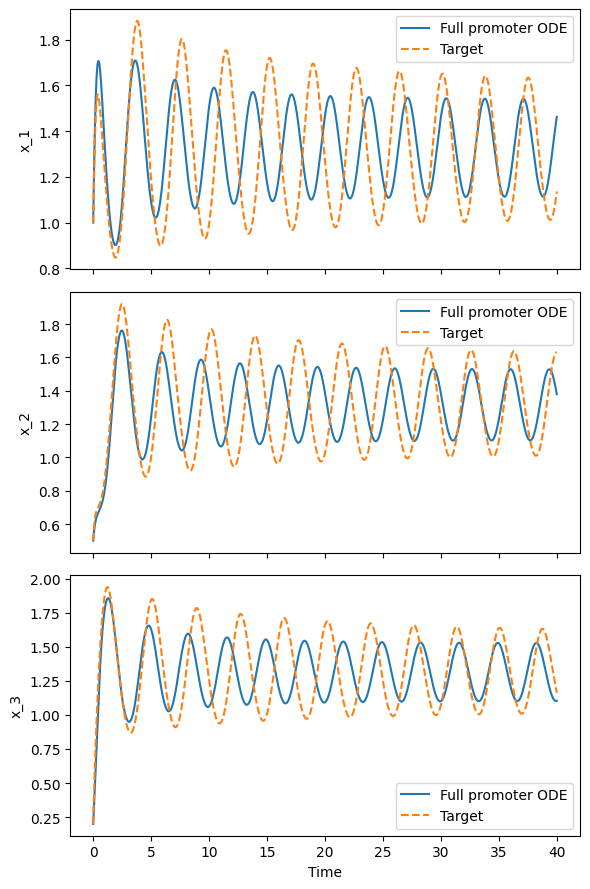

In [95]:
#Plot executive species
fig, axes = plt.subplots(N, 1, figsize=(6, 3 * N), sharex=True)
if N == 1:
    axes = [axes]
for i in range(N):
    axes[i].plot(sol_dyn.t, sol_dyn.y[i], label="Full promoter ODE")
    if sol_tgt is not None:
        axes[i].plot(sol_tgt.t, sol_tgt.y[i], "--", label="Target")
    axes[i].set_ylabel(f"x_{i+1}")
    axes[i].legend(loc="best")
axes[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()